Import required libraries and set random seed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)


Create a neutral content dataset

In [2]:
n_items = 100
categories = ["news", "sports", "politics", "tech", "entertainment"]

content = pd.DataFrame({
    "item_id": range(n_items),
    "category": np.random.choice(categories, n_items),
    "true_quality": np.random.rand(n_items)
})

content.head()


,item_id,category,true_quality
0,0,tech,0.914960
1,1,entertainment,0.850039
2,2,politics,0.449451
3,3,entertainment,0.095410
4,4,entertainment,0.370818


Initial Neutral Recommendation Probabilities

In [3]:
content["recommend_prob"] = 1 / n_items


Simulated User Preference Bias

In [4]:
user_preference = {
    "news": 0.9,
    "sports": 1.0,
    "politics": 0.7,
    "tech": 1.3,
    "entertainment": 1.5
}


Feedback Loop Simulation Function

In [5]:
def simulate_round(content):
    sampled = content.sample(
        n=500,
        weights=content["recommend_prob"],
        replace=True
    )

    sampled["click_prob"] = sampled["category"].map(user_preference) * sampled["true_quality"]
    sampled["clicked"] = np.random.rand(len(sampled)) < sampled["click_prob"]

    clicks = sampled.groupby("item_id")["clicked"].sum()

    content["feedback"] = content["item_id"].map(clicks).fillna(0)

    content["recommend_prob"] = content["recommend_prob"] + 0.05 * content["feedback"]
    content["recommend_prob"] = content["recommend_prob"] / content["recommend_prob"].sum()

    return content


Run Long-Term Feedback Drift

In [6]:
history = []

for i in range(50):
    content = simulate_round(content)
    category_dist = content.groupby("category")["recommend_prob"].sum()
    history.append(category_dist)

history_df = pd.DataFrame(history)
history_df.head()


category,entertainment,news,politics,sports,tech
recommend_prob,0.267433,0.163218,0.092720,0.249808,0.226820
recommend_prob,0.279321,0.143958,0.064471,0.254044,0.258206
recommend_prob,0.347769,0.126303,0.039508,0.222431,0.263990
recommend_prob,0.364152,0.093950,0.026675,0.220472,0.294751
recommend_prob,0.416024,0.048991,0.018273,0.236423,0.280289


In [13]:
history_df.index = range(len(history_df))


Visualize Echo Chamber Formation

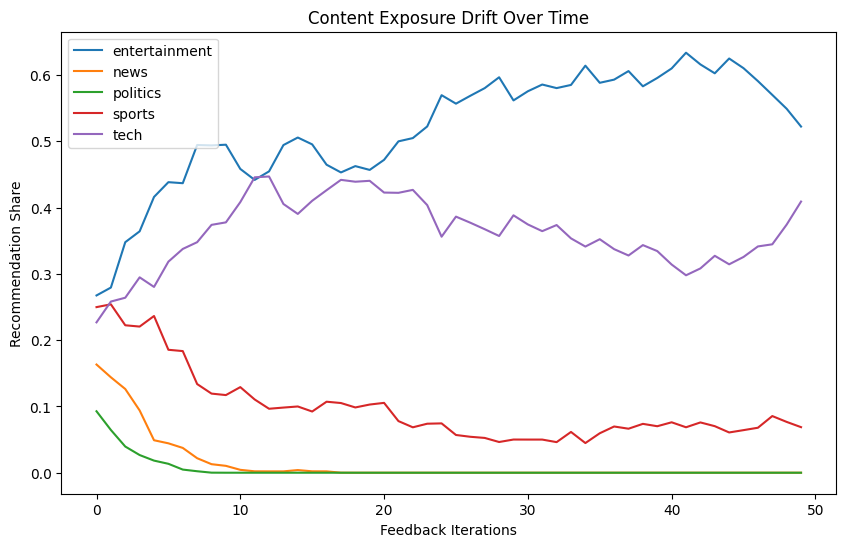

In [15]:
plt.figure(figsize=(10,6))

for col in history_df.columns:
    plt.plot(history_df.index, history_df[col], label=col)

plt.xlabel("Feedback Iterations")
plt.ylabel("Recommendation Share")
plt.title("Content Exposure Drift Over Time")
plt.legend()
plt.show()


**Reinforcement Bias Analysis**

Measure Diversity Collapse

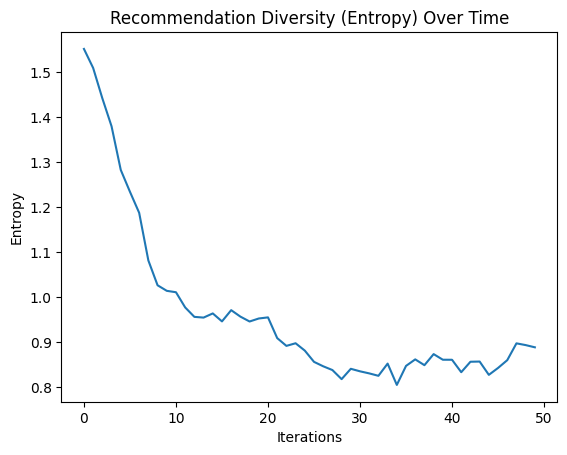

In [16]:
def entropy(dist):
    return -np.sum(dist * np.log(dist + 1e-9))

entropy_values = history_df.apply(entropy, axis=1)

plt.plot(entropy_values)
plt.title("Recommendation Diversity (Entropy) Over Time")
plt.xlabel("Iterations")
plt.ylabel("Entropy")
plt.show()


**Second-Order Effects**

Adaptive User Behavior

In [17]:
def adapt_preferences(current_pref, dominant_category):
    current_pref[dominant_category] *= 1.05
    return current_pref

for i in range(20):
    dominant = history_df.iloc[i].idxmax()
    user_preference = adapt_preferences(user_preference, dominant)


**Failure Mode Table**

In [18]:
failure_modes = pd.DataFrame({
    "Failure Mode": [
        "Echo Chambers",
        "Popularity Bias",
        "Silent Accuracy Decay",
        "Loss of Fairness",
        "Manipulation Risk"
    ],
    "Severity": [5,4,5,4,4],
    "Likelihood": [5,5,4,4,3],
    "Reversibility": [2,2,1,2,3]
})

failure_modes


,Failure Mode,Severity,Likelihood,Reversibility
0,Echo Chambers,5,5,2
1,Popularity Bias,4,5,2
2,Silent Accuracy Decay,5,4,1
3,Loss of Fairness,4,4,2
4,Manipulation Risk,4,3,3


Feedback Decay + Exploration


In [19]:
def safe_simulate_round(content, decay=0.9, exploration=0.1):
    content["recommend_prob"] *= decay

    sampled = content.sample(n=500, weights=content["recommend_prob"], replace=True)
    sampled["click_prob"] = sampled["category"].map(user_preference) * sampled["true_quality"]
    sampled["clicked"] = np.random.rand(len(sampled)) < sampled["click_prob"]

    clicks = sampled.groupby("item_id")["clicked"].sum()
    content["feedback"] = content["item_id"].map(clicks).fillna(0)

    content["recommend_prob"] += 0.03 * content["feedback"]
    content["recommend_prob"] += exploration * (1/len(content))
    content["recommend_prob"] /= content["recommend_prob"].sum()

    return content


Compare Safe vs Unsafe

In [20]:
content_safe = content.copy()
safe_history = []

for i in range(50):
    content_safe = safe_simulate_round(content_safe)
    safe_history.append(content_safe.groupby("category")["recommend_prob"].sum())

safe_df = pd.DataFrame(safe_history)


Visual Comparison

In [22]:
safe_df = safe_df.reset_index(drop=True)


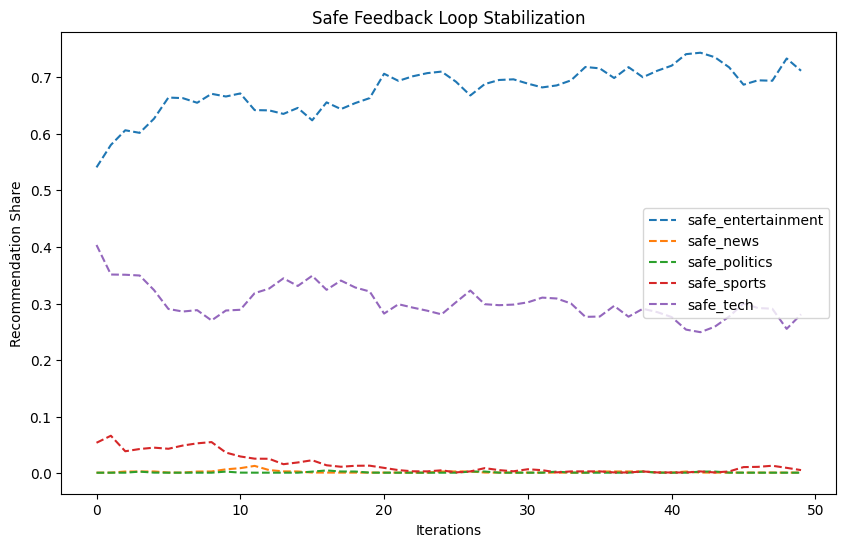

In [25]:
plt.figure(figsize=(10,6))

for col in safe_df.columns:
    plt.plot(safe_df[col], linestyle="--", label=f"safe_{col}")

plt.title("Safe Feedback Loop Stabilization")
plt.xlabel("Iterations")
plt.ylabel("Recommendation Share")
plt.legend()
plt.show()
